In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
# 跳转文件目录到当前文件运行的文件夹。
path = "/content/drive/My Drive/Colab Notebooks/RAE"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['RAE.ipynb',
 'outputs',
 'models',
 'ImShow.py',
 'RAE_with_noise',
 'RAE_with_noise.ipynb',
 'RAE_with_noise_improved.ipynb',
 'noise_generator',
 'RAE_with_noise_improved.ipynb（副本）',
 'shrink',
 'AddNoise',
 '__pycache__',
 'model',
 'data',
 'RAE_l21_Instance_Detection.ipynb',
 'RAE_l21_Anomalous_Feature.ipynb',
 'RAE_with_noise_improved(Add VAE).ipynb']

# Load package

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


import torch.nn.functional as F
from torch import nn, optim
import torch
from torch import optim
from torchvision import datasets, transforms

# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Import the model and methods that defined by us

In [3]:
from AddNoise import addnoise
from model.DeepAutoencoder import DAE
import ImShow as I

from shrink import l21shrink as SHR
from model.train import train 

In [4]:
BATCH_SIZE = 100

LEARNING_RATE = 1e-3

EPOCH = 10

data = np.load('./data/data.npk', allow_pickle=True)
y = np.load("./data/y.npk", allow_pickle=True)
torch.tensor(data).shape

train_data = torch.tensor(data)
train_label = torch.tensor(y).view((5124,1))


## Robust Deep autoencoder (Anomalous feature)

In [5]:
class RDAE(object):
  def __init__(self, lambda_=1.0, error=1.0e-5):
    super(RDAE,self).__init__()
    self.lambda_ = lambda_
    self.error = error
    self.AE = DAE()

  def fit(self, X):
    self.AE.to(device)
    optimizer = optim.Adam(self.AE.parameters(), lr=LEARNING_RATE)
    error = self.error
    lambda_ = self.lambda_

    L = torch.zeros(X.shape)
    S = torch.zeros(X.shape)

    LS0 = L + S

    XFnorm = torch.norm(X, 'fro')
    mu = (len(X))/(4.0 * torch.norm(X, 1))

    # move to the device
    X = X.to(device)
    L = L.to(device)
    S = S.to(device)
    LS0 = LS0.to(device)

    # add noise to X
    # X = addnoise.add_noise_uniform_normal(X, 100)

    for i in range(5):
      # updata L
      L = X - S

      # generate train data
      train_datas = torch.utils.data.DataLoader(L, batch_size = BATCH_SIZE, shuffle=False)
      
      train(train_datas, self.AE, optimizer, 10)
      
      with torch.no_grad():
        # get optimized L
        L = self.AE(L.float())
        
        # S = shrink_anomly(lambda_/mu, (X-L))
        S = SHR.shrink(lambda_, (X-L))

      # break criterion 1: the L and S are close enough to X
        c1 = torch.norm(X-L-S, 'fro') / XFnorm

      # break criterion 2: there is no changes for L and S
        c2 = torch.min(mu, torch.sqrt(mu)) * torch.norm(LS0 - L - S) / XFnorm

        if c1 < error and c2 < error:
          print("early break")
          break
      LS0 = L + S
    return L, S

=========lambda======= 15


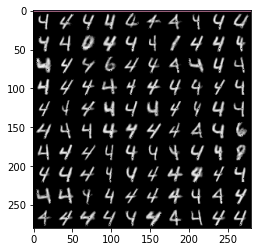

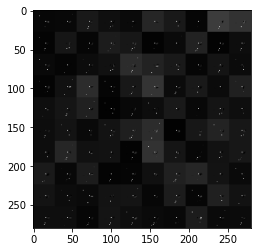

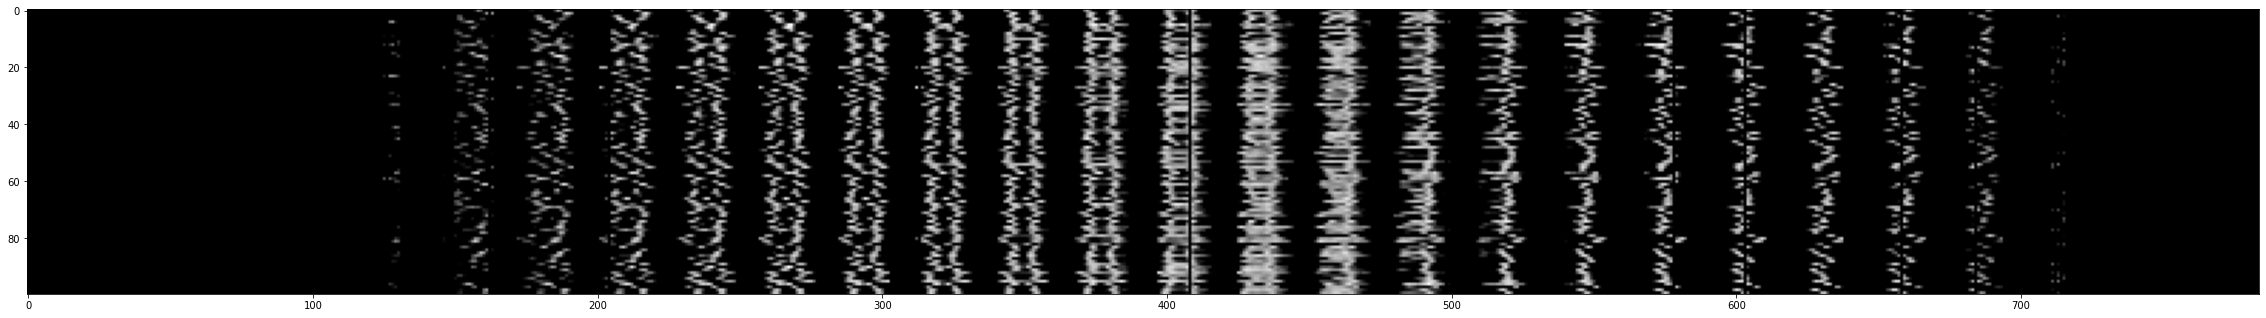

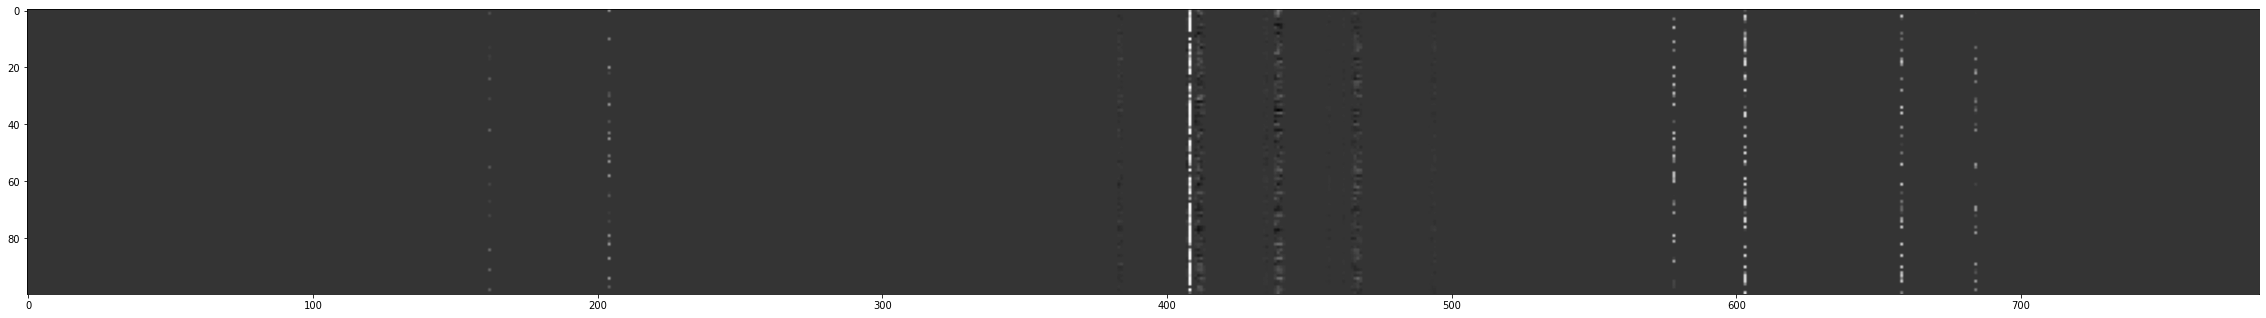

=========lambda======= 25


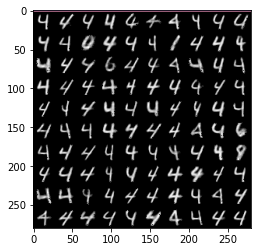

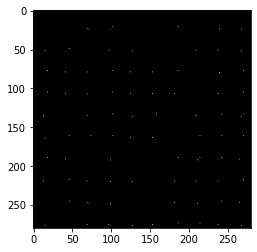

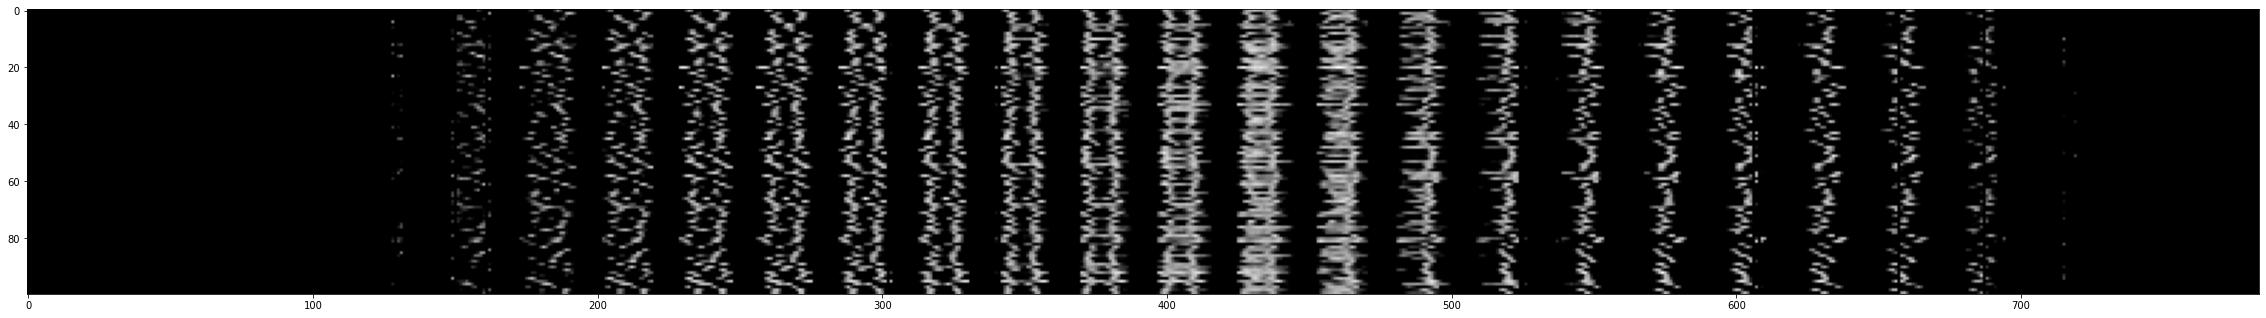

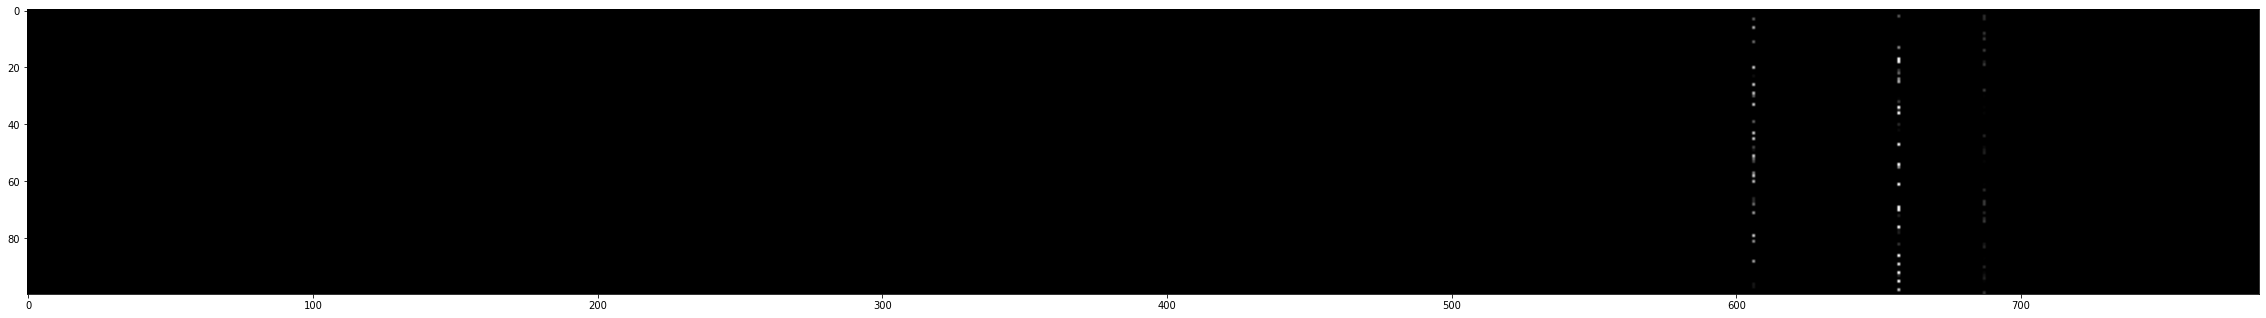

=========lambda======= 30


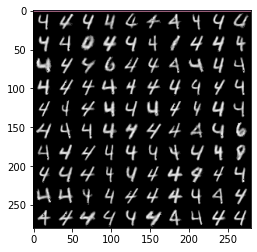

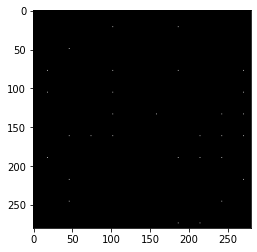

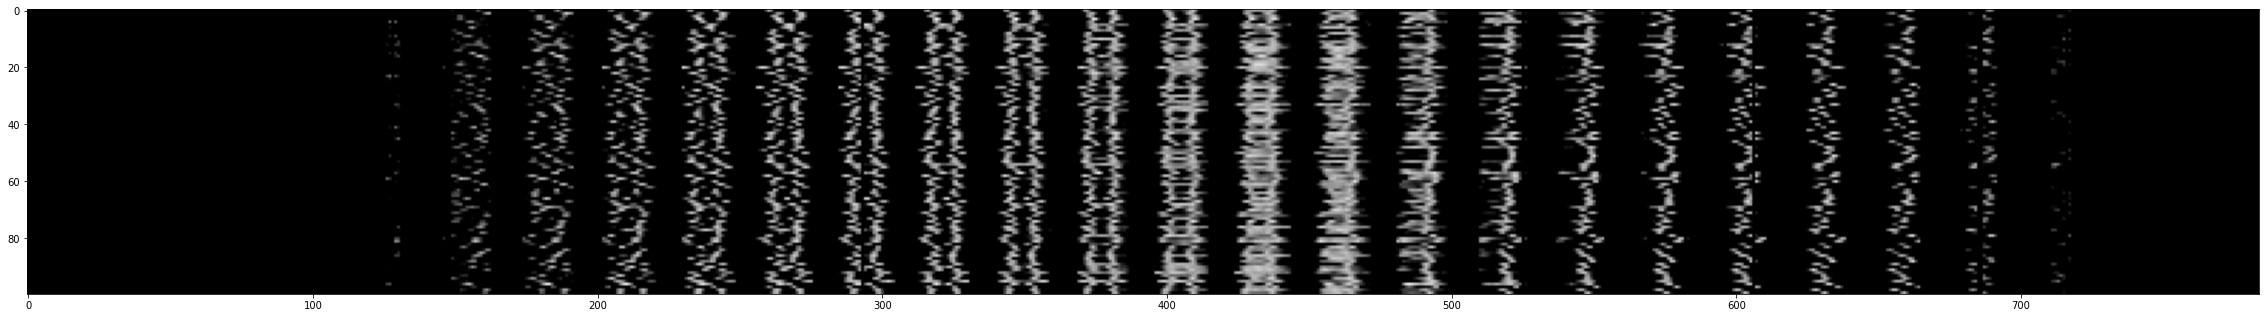

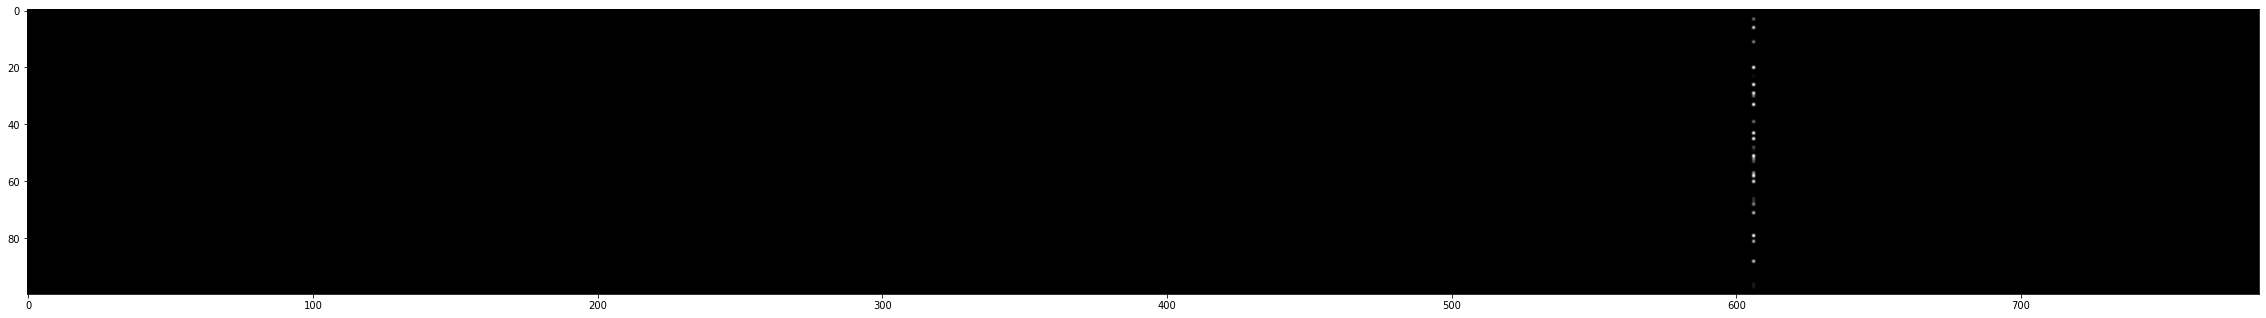

In [20]:
lambdas = [15,25,30]

result = []

for i in lambdas:
  print("=========lambda=======", i)
  model_RDAE = RDAE(lambda_=i)
  L, S = model_RDAE.fit(train_data)
  L = L.cpu().numpy()
  S = S.cpu().numpy()

  L_pics = I.tile_raster_images(L, (28,28), (10,10))
  S_pics = I.tile_raster_images(S, (28,28), (10,10))

  plt.imshow(L_pics, cmap='gray')
  plt.show()
  plt.imshow(S_pics, cmap='gray')
  # plt.savefig("outputs/%.4f.png"%(i))
  plt.show()
  plt.figure(figsize=(40,20))
  plt.imshow(L[:100],cmap='gray')
  plt.show()
  plt.figure(figsize=(40,20))
  plt.imshow(S[:100],cmap='gray')
  plt.show()